# Bonus Module - Convolutional Neural Networks

Fully connected neural networks are great, but they are not a one size fits all solution. For instance, if we have a sequence of data, like text or sound, each data point has a context. If it's a sentence, then you need to know the preceding words to know the meaning of the current word. If it's sound, the current note may be part of a longer phrase which creates a melody. However, if we just use a fully connected neural network, we cannot use what has come before or after as context to the current input. In other words we can give it a single piece of the sequence with no context. For example, if I asked you what the word "for" means with no context, you would have a hard time. 

Recurrent neural networks are one way to handle sequential data. They are just like fully connected neural networks except they have looping connections. Loops allow the network to view the current input and state created from previous inputs as context. 

Another task fully connected networks struggle with is image recognition. Often, images have hundreds of thousands of pixels. Because we have to flatten all these pixels into a one dimensional list to feed them into a fully connected network, we need a ton of weights (more than one for each pixel). Not to mention the weights in subsequent hidden layers. In addition, since we flatten the image, we lose information about its structure which is inherently two dimensional. For example, if an image contains a face, we do not care where the face is or how many faces there are. Ideally, if we found some weights that can represent a face, we would not have to duplicate them for every part of the image. We could simply reuse the "face recognizer" over the entire image. This is where convolutional networks come in.

Convolutional networks solve the problem of efficiency and repetition when learning from images. Instead of connecting every pixel to a neuron, convolutional neural networks (CNN's) have a set of filters. A filter is just a matrix of weights (how important is each element). With one filter we can turn multiple pixel values into one number. We do this by overlaying the filter matrix on the image. Each element of the filter matrix "covers" one pixel. That pixel value is multiplied by the weight in the corresponding position of the filter. Once we multiply all the pixels "under" the filter we add them up and then add a bias. This process is very similar to our fully connected neuron wherein we multiply weights by inputs and add a bias. However, we are not done. The next step is to slide the filter over and repeat. When the filter reaches the furthest side of the image, it wraps down to the next row and continues. Because the filter turns multiple pixels into a single value, we end up with an "image" which is now smaller than the original. This resulting image is called a feature map because it maps the input image into a certain feature. For example, if we had an edge filter, the resulting feature map of that filter would have a high value (white) where an edge exists and a low value (black) where edges don't exist. The resulting image essentially looks like white lines drawn on a black sheet where each line is some edge in the original picture. Similarly, there may be a filter for detecting large areas of the same color. This filter may be useful in finding continuous surfaces that represent one object versus another. 

Filters are generally much smaller than the image, say a 5 X 5 matrix, and we may only have 10 or 20 of them. This significantly reduces the number of weights we need for the image. If we have an image of 100 X 100 pixels and we used a fully connected network, we would need 10,000 weights for every neuron in the first layer. However, with our filters we only need (5 X 5) X 20 = 500 weights for the first layer! This also solves the repetition problem because we take each filter and "slide" it across the entire image. In other words, if one filter learned to recognize faces, we could reuse that same filter for every face in the image.


# Convolution

In [2]:
import numpy as np


# a convolution operation involves multiplying
# the elements of a and b and summing them up 

a = np.array(
    [[1, 2, 3], 
     [4, 5, 6], 
     [7, 8, 9]])

b = np.array(
    [[9, 8, 7], 
     [6, 5, 4], 
     [3, 2, 1]])

np.sum(a * b)

165

# Sliding the filter across the image

In the example above, b can be considered the filter which we apply to a. However, the filter is often much smaller than the data it operates on. If the data is an image like in our case we expect the image to be much larger than 3x3. For the sake of simplicity we can make an "image" that is 10x10 and "slide" the filter b across it. As we slide we can move the filter by one pixel each time or more than one. The number of pixels we move the filter by is called the stride. Try out different stride lengths to see how the filter movement differs.

As you may imagine, as soon as we introduce a stride, we have to worry about whether the image has the right dimensinos. If the image size is not an even multiple of the stride, we will miss some of the image. To solve this problem we can instroduce padding so that every pixel is hit by the filter.

<IPython.core.display.Javascript object>


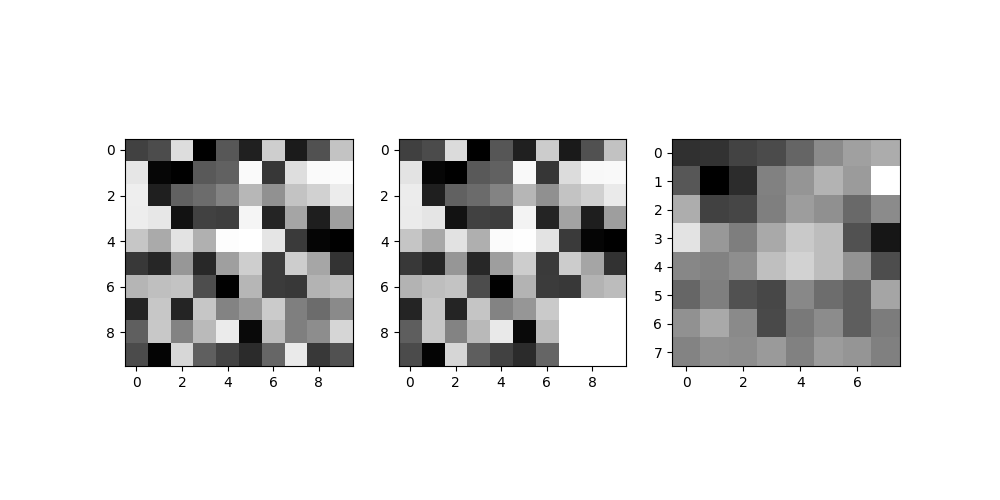

In [110]:
%matplotlib notebook
import time
from math import floor
import matplotlib.pyplot as plt

image = np.random.random(size=(10, 10))
f = np.random.random(size=(3, 3))
fig = plt.figure(figsize=(10, 5))

# create figures for each of the displays (image, sliding filter, feature map)
im_ax = fig.add_subplot(1,3,1)
slide_ax = fig.add_subplot(1,3,2)
fmap_ax = fig.add_subplot(1,3,3)

im_ax.imshow(image, cmap='gray')

x = image.shape[0] - f.shape[0] + 1
y = image.shape[1] - f.shape[1] + 1


feature_map = np.ones(shape=(x, y))


with_filter = np.copy(image)

for i in range(x):
    for j in range(y):
        # clear the axis to redraw
        slide_ax.clear()
        fmap_ax.clear()

        # show the filter at its current location on the image
        with_filter[i:i + f.shape[0], j:j + f.shape[1]] = np.ones(shape=(3,3))

        # apply the convolution operation to the image and save the result
        feature_map[i, j] = np.sum(image[i:i + f.shape[0], j:j + f.shape[1]] * f)

        # display the image with the filter overlay and the updated feature map
        slide_ax.imshow(with_filter, cmap='gray')
        fmap_ax.imshow(feature_map, cmap='gray')

        # reset the image copy to remove the filter
        with_filter[i:i + f.shape[0], j:j + f.shape[1]] = image[i:i + f.shape[0], j:j + f.shape[1]]

        fig.canvas.draw()
        plt.show()
        time.sleep(.2)

# Feature Extraction

We have seen how to slide a filter over an image and apply the convolution operation, but it didn't do anything useful. The whole point of the filter is to pickup on some pattern in the image like an edge or certain shape. When the filter actually does something useful we call it a feature extractor because it highlights something in the image. One such filter is for edge detection. If we use an actual image and this edge detection filter we can see how the edges are highlighted. After the convolution operation, we apply an activation function to produce the final feature map.

Because different filters extract different features, we want one convolutional layer to use many filters instead of creating many parallel convolutional layers.

<IPython.core.display.Javascript object>


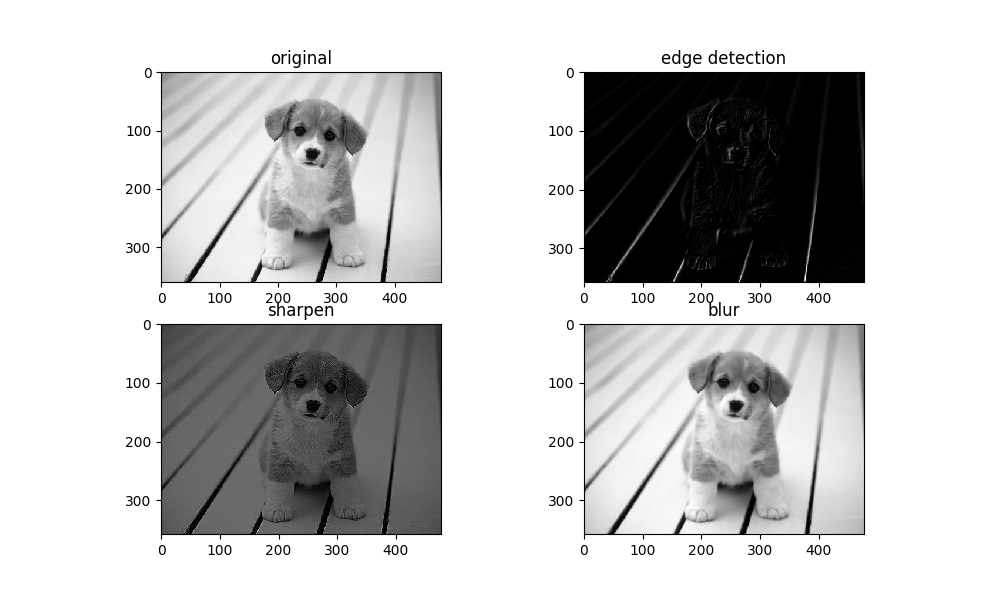

In [109]:
# lets import an image from the hand written digit dataset which contains a set of images of size 8 x 8
from PIL import Image
import requests
from io import BytesIO

# !!! PUPPY PIC !!!
url = 'https://i.ytimg.com/vi/opKg3fyqWt4/hqdefault.jpg'
response = requests.get(url)
image = np.array(Image.open(BytesIO(response.content)))

# average the rgb values together to make a grayscale image
gray_img = np.mean(image, axis=2)

def relu(z):
    return max(0, z)


class ConvLayer:
    def __init__(self, filters, activation=relu):
        self.filters = filters
        self.activation = activation
    
    def __call__(self, image):
        # create one feature map for each type of filter
        feature_maps = []
        
        for f in self.filters:
            x = image.shape[0] - f.shape[0] + 1
            y = image.shape[1] - f.shape[1] + 1

            feature_map = np.ones(shape=(x, y))

            # slide the edge detection filter over the image
            # to create a feature map for each filter
            for i in range(x):
                for j in range(y):
                    # convolution operation
                    conv = np.sum(image[i:(i + f.shape[0]),j:(j + f.shape[1])] * f)
                    # activation function
                    feature_map[i,j] = self.activation(conv)
                                  
                                  
            feature_maps.append(feature_map)
                
        return np.array(feature_maps)

    
# edge detection filter
edge_filter = np.array(
    [[2, 4, -2],
     [4, 0, -4],
     [2, -4, -2]])

sharpen_filter = np.array(
    [[0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]])

blur_filter = np.array(
    [[0.0625, 0.125, 0.0625],
     [0.125,  0.25,  0.125],
     [0.0625, 0.125, 0.0625]])

# because we pass the edge detection filter into 
# our convolutional layer, we have created an edge detector

filters = [edge_filter, sharpen_filter, blur_filter]
conv_layer = ConvLayer(filters)

feature_maps = conv_layer(gray_img)


plt.figure(figsize=(10, 6))


plt.subplot(221)
plt.title('original')
plt.imshow(gray_img, cmap='gray')

plt.subplot(222)
plt.title('edge detection')
plt.imshow(feature_maps[0], cmap='gray')

plt.subplot(223)
plt.title('sharpen')
plt.imshow(feature_maps[1], cmap='gray')

plt.subplot(224)
plt.title('blur')
plt.imshow(feature_maps[2], cmap='gray')

In [39]:
# ======================================= DOGS ============================================
# This is the section about dogs and how awesome they are!

# DOGS DOGS DOGS DOGS DOGS DOGS DOGS DOGS DOGS DOGS DOGS DOGS DOGS DOGS DOGS DOGS DOGS DOGS

# This is a dog matrix
np.array(
    [['dog', 'dog', 'dog'],
    ['dog', 'dog', 'dog'],
    ['dog', 'dog', 'dog']])

# there are endless types of dog data structures
# ======================================= DOGS ============================================

array([['dog', 'dog', 'dog'],
       ['dog', 'dog', 'dog'],
       ['dog', 'dog', 'dog']], dtype='<U3')

# Down Sampling

We have figured out how to pull certain features out of the images, but we still have a ton of pixels to deal with. After applying the filter, the image is a little smaller, but only by the size of the filter. Ultimately, we want to reduce the size of the image to less than a few hundred data points. Once the image is reduced to this size the idea is that only relevent information remains. In other words if we are trying to find road signs, the reduced vector would have elements that encode the presence of written text, sign shapes, certain colors, or any other information needed to decide if there's a sign. The reduced image is then fed through a fully connected neural network just like the one from the other modules. The fully connect network is then responsible for classifying the sign or whatever we want. 

In addition to applying filters to reduce the image size, we can combine multiple elements from the feature map into one. There are several ways to combine featue map elements. One is called max pooling. Using max pooling, we start off with a 2 dimensional area similar to the filter size for instance 2x2, 4x4, etc. We slide this 2 dimensional region, called a receptive field, across the feature map and only keep the maximum value of the current set of elements. This entire operation is referred to as a pooling layer and is very common in convolutional neural network architecture. In addition to max pooling there is also average pooling, where instead of taking the max, we take the average. Average pooling is preferred to max pooling because information is lost when we simply throw values away. 

Another feature of pooling is that we don't just slide the receptive field by 1 pixel each time. Instead, after pooling over the receptive field, we move it over so there is no overlap with the already pooled pixels. This greatly reduces the size of the feature map as you can imagine. Even a receptive field of size 2x2 cuts the feature map or image in half. We only need to pool a few times to reduce the original image down to a managable size.

Moving the receptive field so that there is no overlap from the previous interation is one way, but we could also allow some overlap. However, When we do so we have to ensure that every pixel in the image will pass through the pooler's receptive field. This different slide size is called a stride and it can also be applied to the convolution operations if desired. The stride length simply says how much we move the receptive field or filter over by in each iteration.

<IPython.core.display.Javascript object>


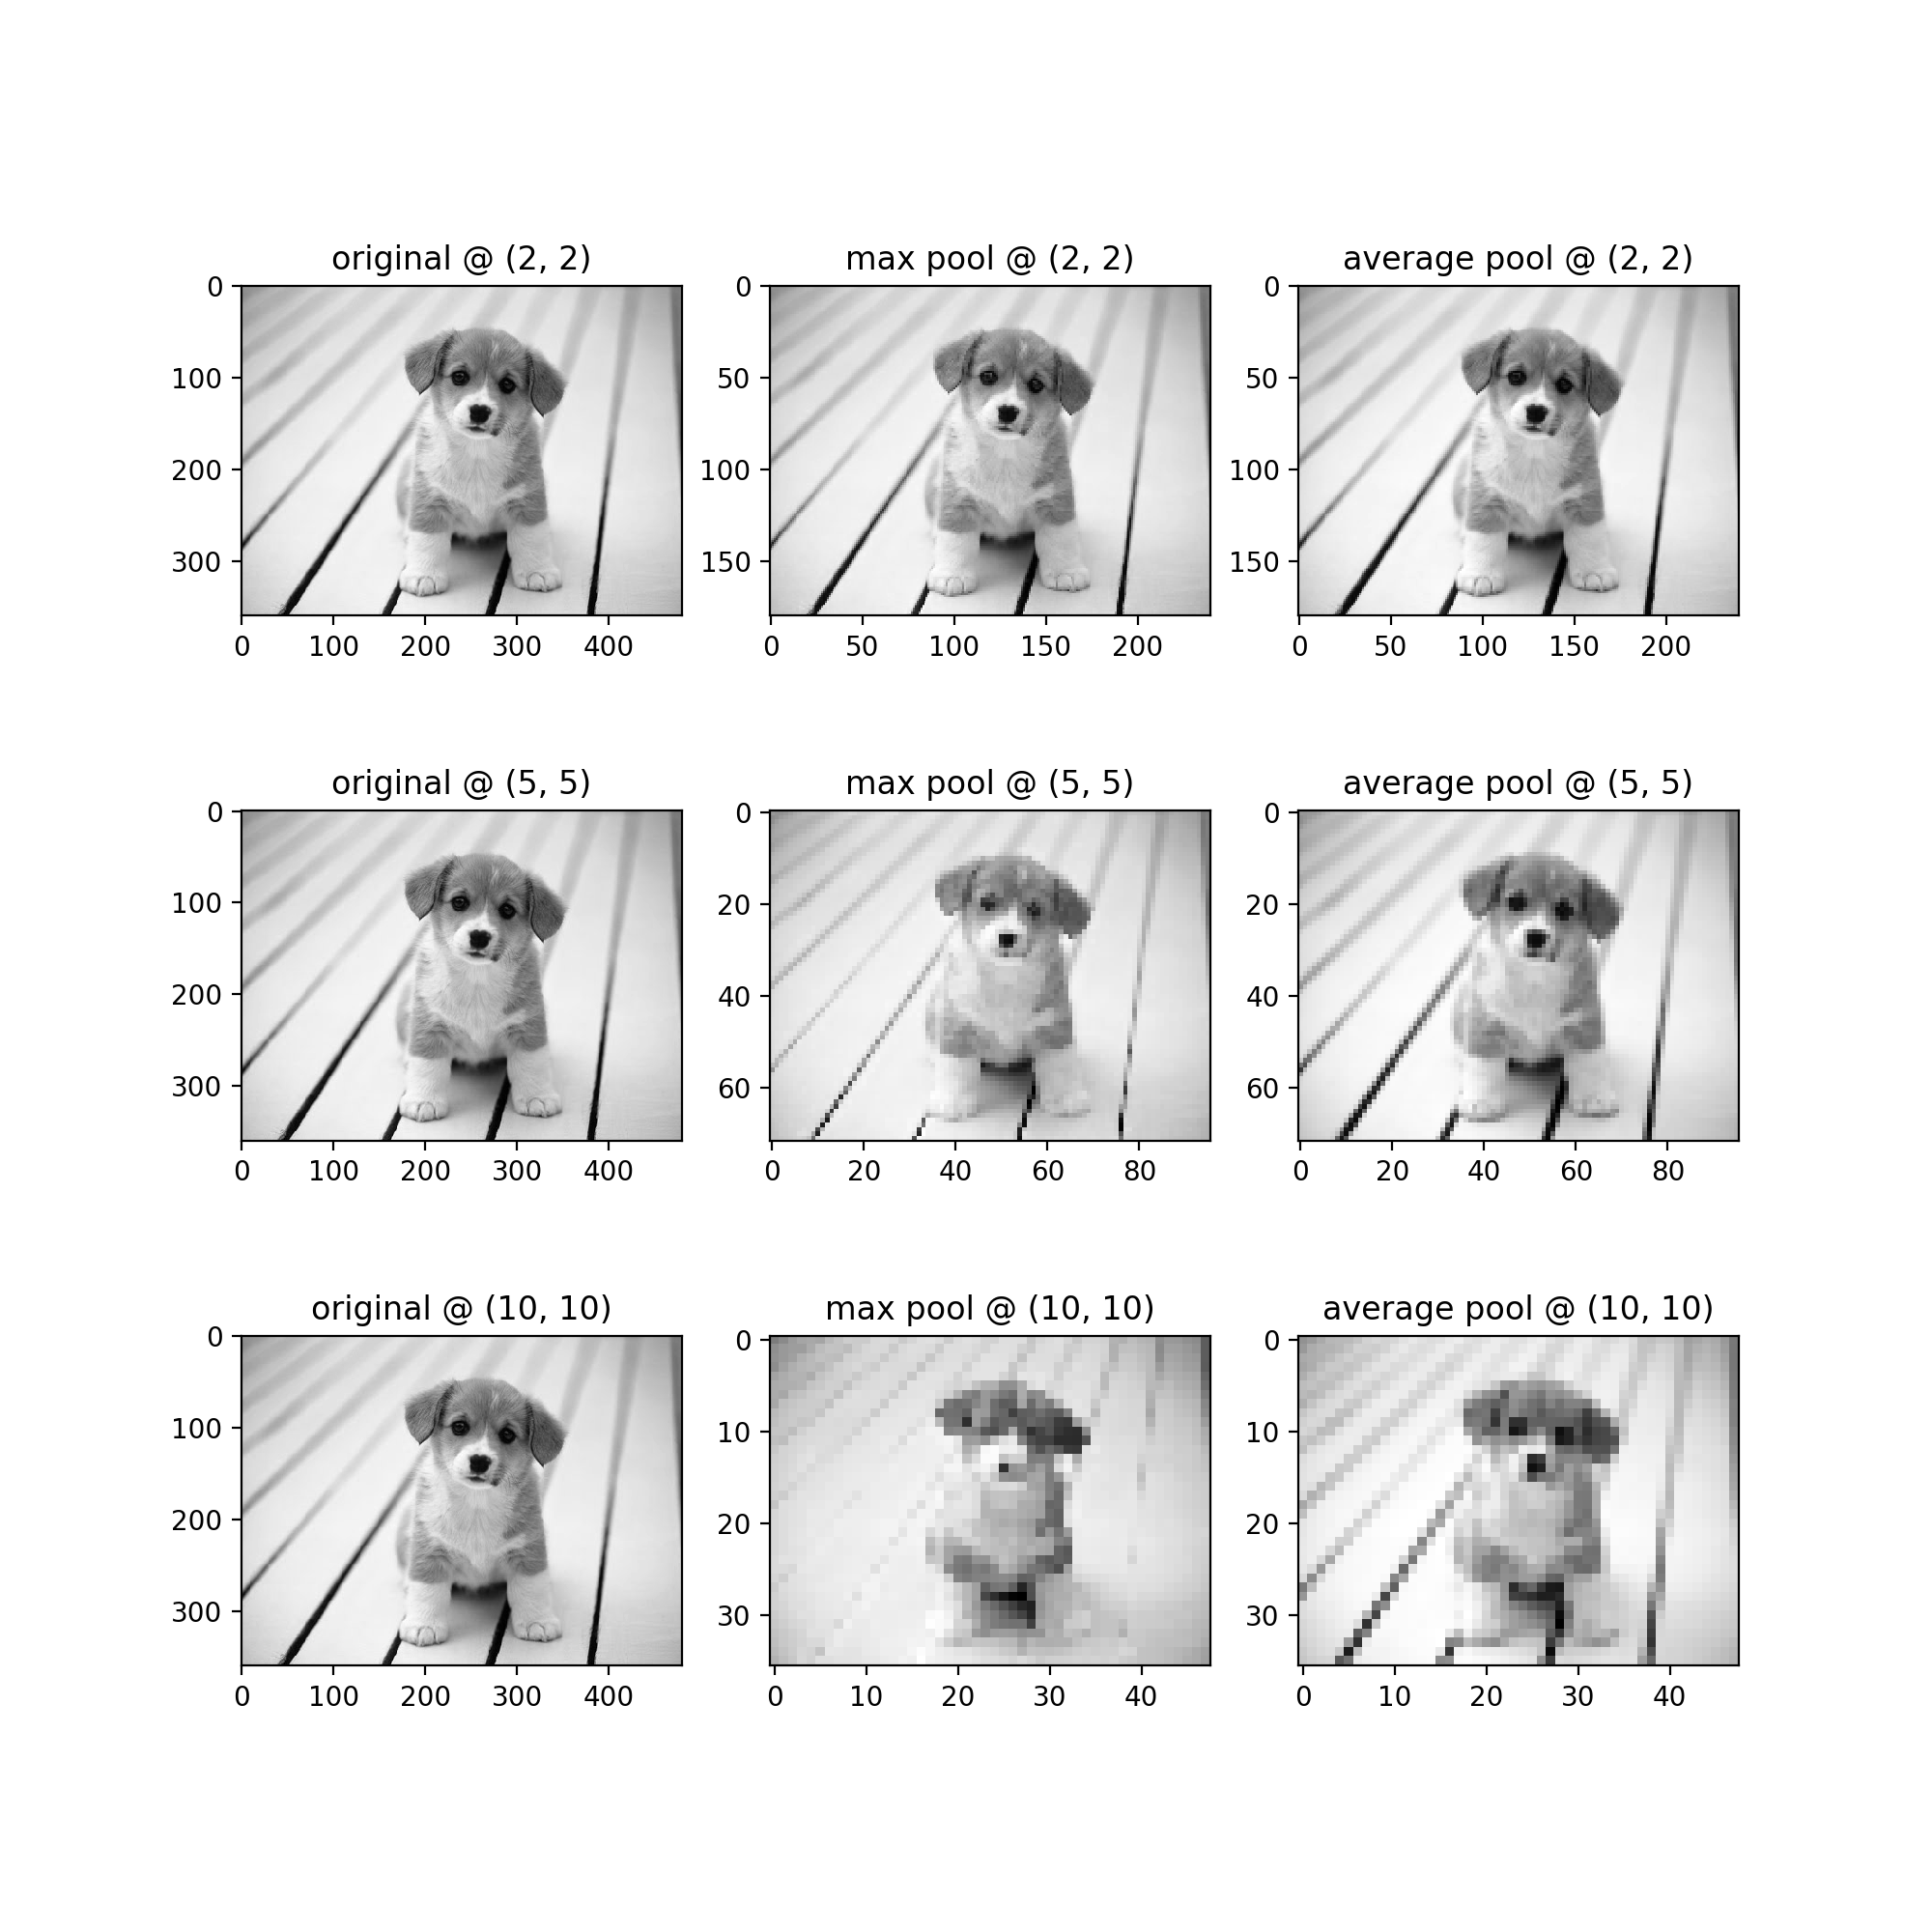

In [101]:
%matplotlib notebook
from statistics import mean

class PoolLayer:
    def __init__(self, pooler, dim):
        # a pooler is a function that takes in multiple values and returns one
        self.pooler = pooler
        # the dimensions of the receptive field to pool
        self.rec_field = dim
    
    def __call__(self, data):
        rf_x = self.rec_field[0]
        rf_y = self.rec_field[1]
        
        x = int(data.shape[0]/rf_x)
        y = int(data.shape[1]/rf_y)
        
        output = np.zeros(shape=(x, y))
        
        for i in range(x):
            for j in range(y):
                field = data[i*rf_x:(i+1)*rf_x, j*rf_y:(j+1)*rf_y]
                output[i,j] = self.pooler(field.flatten())
        
        return output
    

# the size of the image must be a multiple of the size of 
# the receptive field or we have to adjust the stride
receptive_fields = [(2, 2), (5, 5), (10, 10)]
plt.figure(figsize=(10, 10))
    
for (i, rf) in enumerate(receptive_fields):
    max_pooler = PoolLayer(max, rf)
    avg_pooler = PoolLayer(mean, rf)

    plt.subplot(3, 3, (i*3)+1)
    plt.title( 'original @ {}'.format(rf))
    plt.imshow(gray_img, cmap='gray')

    plt.subplot(3, 3, (i*3)+2)
    plt.title('max pool @ {}'.format(rf))
    plt.imshow(max_pooler(gray_img), cmap='gray')

    plt.subplot(3, 3, (i*3)+3)
    plt.title('average pool @ {}'.format(rf))
    plt.imshow(avg_pooler(gray_img), cmap='gray')


# Architecture

Now we can create a full convolutional neural network (CNN)! We have all the pieces we need here except the fully connected layers that we built in the course which I have included to import here. Generally, when we build a CNN there will be many sections which consist of a convolutional layer and a pooling layer. After that there are several fully connected layers which give our final output prediction. 

The convolutional layers extract features from the image and the pooling layers reduce the amount of data we have to deal with. Because the pooling layers also summarize a region of the image, they help the network find features regardless of their original position.

Up until now we have only used the gray scale image which is simply a 2 dimensional array of numbers. This is a problem for two reasons. One is that images are not usually gray. For instance if the image is 200 x 200 and has RGB then we really have 200 x 200 x 3. We need to allow the network to handle this case. The second reason is that after a convolutional layer, we end up with a bunch of feature maps with one for each filter. How do we feed all these feature maps into subsequent convolutional layers when our initial conv layer can only accept a 2d array? For example if our first convolutional layer outputs 10 feature maps of size 180 x 180 then our next conv layer needs to accept 180 x 180 x 10. 

The solution is to use 3d filters instead of 2d. For instance, if we have an RGB image of size 200 x 200 x 3 then our filter could have size 5 x 5 x 3. This is identical to our 2d filter except we now have one 2d filter for each color channel. Similarly, if a conv layer takes input from a previous conv layer we can have a filter of size 5 x 5 x N where N is the number of feature maps output from the previous layer.

Another trick we can use is called padding. Padding just means we add dummy pixels around the original ones. The padding of extra pixels allows the feature maps from a conv layer to be the same size as their input. This way we don't have to worry about making sure the output of one layer matches the input to the next. Whatever the input size is, that is the output size. Now only the pooling layers perform downsampling because the conv layers no longer reduce the size of the image. This also makes computing the final output from the conv and pool layers very easy. If our pool layer has a receptive field of 2 x 2, then we just divide the original image dimensions by 2 for every pool layer and we're done.

In [105]:
from network import sigmoid, Network, Layer as FullyConnectedLayer

# the flatten layer will take the output feature maps from our 
# convolutional layers and turn them into a 1 dimensional list
def flattenLayer(x):
    return x.flatten()



class Conv3D:
    def __init__(self, f, fx, fy, fd):
        self.fx = fx
        self.fy = fy
        self.fd = fd
        self.filters = [np.random.random(size=(fx, fy, fd)) for i in range(f)]
        
    def add_padding(self, data):
        # we want the feature map to be the same size as the input so we add padding
        # ( original size + ( padding ) ) - filter size + 1 = original size
        # ( data.shape[0] + (self.fx - 1) ) - self.fx + 1 = data.shape[0]
        dx = (self.fx - 1)/2
        dy = (self.fy - 1)/2
        
        np.zeros(size=(data.shape[0] + (dx * 2), dy, self.fd)) + 
        
        np.zeros(size=(data.shape[0] + (dx * 2), dy, self.fd))
        
        
    
    def __call__(self, data):
        for f in self.filters:
            for i in data.shape[0]:
                for j in data.shape[1]:
                    



# pool over all feature maps
class FmPoolLayer:
    def __init__(self, pooler, dim):
        self.pool = PoolLayer(pooler, dim)

    def __call__(self, feature_maps):
        return np.array([self.pool(f) for f in feature_maps]))
    
layers = [
    Conv3D(),
    FmPoolLayer()
#     FmPooler(mean, (2, 2))
]


def forward(data, layers):
    out = data
    
    for l in layers:
        out = l(out)
        print(out.shape)
        
    return out

forward(gray_img, layers)

(2, 358, 478)
(2, 179, 239)
(4, 177, 237)
(4, 88, 118)
(8, 86, 116)
(8, 43, 58)


array([[[ 390.12019465,  385.14753561,  380.29612013, ...,
          544.696257  ,  547.75103451,  553.77537854],
        [ 375.88660388,  375.09389143,  374.33051259, ...,
          545.22549452,  552.56967708,  558.65067242],
        [ 365.34616079,  368.87684352,  372.83716449, ...,
          549.39074578,  557.41360889,  563.61306629],
        ...,
        [ 445.28700828,  464.5730801 ,  483.13804035, ...,
          514.50416646,  509.10903914,  507.29043552],
        [ 464.16033295,  484.76956498,  500.47350784, ...,
          507.3104873 ,  505.72622428,  508.05303561],
        [ 489.81318543,  507.41766443,  515.14088408, ...,
          504.94924661,  507.4052907 ,  513.84848036]],

       [[ 712.03670964,  703.23922207,  695.00857836, ...,
          997.695246  , 1004.18255852, 1015.31185502],
        [ 685.21949407,  684.8087103 ,  684.59717492, ...,
          999.70097824, 1013.4802051 , 1024.58807881],
        [ 667.95737286,  675.32770671,  683.7995694 , ...,
         1007.